In [28]:
from rules_extraction.rule_handler import RuleHandler
from rules_extraction.data_processor import DataProcessor
from rules_extraction.random_forest_trainer import RandomForestTrainer
from rules_extraction.result_plotter import ResultPlotter
from scripts.vgg16 import FineTunedVGG
from scripts.sport_dataset import SportsData
from scripts.helpers import *

import os
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
import json

from sklearn.model_selection import train_test_split


In [2]:
# load instance
model = FineTunedVGG()
model = model.to(torch.device("cuda:1"))
load_dict("/mnt/remote/workspaces/arthur.babey/hes-xplain-arthur/use_case_sport_classification/models/saved_models/VGGFineTuned.pth", model)
train_loader, valid_loader, test_loader = get_dataloaders()

From here we will only use test_loader because of storage issue, training method were done previously and the result are stored in this folder

In [3]:
data = DataProcessor(model = model, train_dataloader = train_loader, test_dataloader = test_loader, device = torch.device("cuda:1"))

In [4]:
# filter the training dataset. This can not be done because we did not uploader training data
# data.filter_dataset(test_data = False)

In [5]:
# filter the test data, which initialize an attribute called filtered_test_dataloader

data.filter_dataset(test_data=True)

In [6]:
# use mapping to have real class names

file_path = 'data/class_dict.json'
with open(file_path, 'r') as file:
    class_dict = json.load(file)
inverted_dict = {v: k for k, v in class_dict.items()}



In [7]:
# create binary dataset with target_class = 1 using the filtered traning data
# this need training data, the output of this function is stored in binary_dataset_train/amputefootball_filtered.csv

# data.process_dataset(target_class=1, extract_features=data.extract_features_vgg, filter = True, class_dict = class_dict, test_data=False)

In [8]:
# create test csv dataset with target class = 1 and using the filtered data
data.process_dataset(target_class=1, extract_features=data.extract_features_vgg, filter = True, class_dict = class_dict, test_data=True)


Your new data, with target class 'amputefootball', has been created and saved to: binary_dataset_test/amputefootball_filtered.csv


In [9]:
df_train = pd.read_csv("./binary_dataset_train/amputefootball_filtered_good.csv")
df_train = df_train.drop(columns=['Unnamed: 0', "label", "path"])  # drop non-feature columns

In [44]:
df_test = pd.read_csv("binary_dataset_test/amputefootball_filtered.csv")
df_test = df_test.drop(columns=['Unnamed: 0', "label", "path"])  # drop non-feature columns

# extract test data from the test set 

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:,-1]

In [45]:
# initialize a random forest model on the training data
# it assumes that the last column is binary label and all other columns are feature
rf_trainer = RandomForestTrainer(dataset = df_train)

In [46]:
# train a rf model, parameter from sklearn can be used
# test_size and random state are also used for the train/test function 

rf_trainer.fit(test_size=0.2, n_estimators=100, max_depth=2, random_state=1)

In [47]:
# this allow to get the same train, test split done during the training
# i.e we can have the "validation" data

X_train, X_val, y_train, y_val = train_test_split(
            rf_trainer.dataset[rf_trainer.feature_columns], rf_trainer.dataset[rf_trainer.target_column], test_size=0.2, random_state=1
        )

In [50]:
print(f"Accuracy of the random forest on the test set (only 10 points) {rf_trainer.evaluate(X_test, y_test):.3}")
print(f"Accuracy of the random forest on the validation set {rf_trainer.evaluate(X_val, y_val):.3}")

Accuracy of the random forest on the test set (only 10 points) 1.0
Accuracy of the random forest on the validation set 0.951


In [52]:
# extract rules from the training RF model
all_rules = rf_trainer.extract_all_rules()
# initialize RuleHandler object using all rules extracted from the RF
rule_handler = RuleHandler(rules=all_rules)

Number of rules is 397


In [53]:
# transform data to binary rules
X_train_rules = rule_handler.data_to_rules(X_train)
X_test_rules = rule_handler.data_to_rules(X_test)


In [54]:
# fit a percpetron on training and evaluate on test set
rule_handler.fit_perceptron(X_train, y_train, random_state = 1)
rule_handler.evaluate_perceptron(X_test, y_test)

0.9

In [55]:
# extract the top 30 rules 
top_30_rules = rule_handler.rank_rules(N=30)

In [56]:
# compute the accuracy on the test set using top 3 rules 
rule_handler.score(X_test, y_test, top_30_rules[:3])

1.0

In [57]:
# initialize a plotter object and plot the result on test and val dataset using up to N=
plot = ResultPlotter(rules=top_3_rules)
plot.plot_accuracy(X_test, y_test, class_name = class_dict.get("1"), N=9)
plot.plot_accuracy(X_val, y_val, class_name = class_dict.get("1"), N=9)

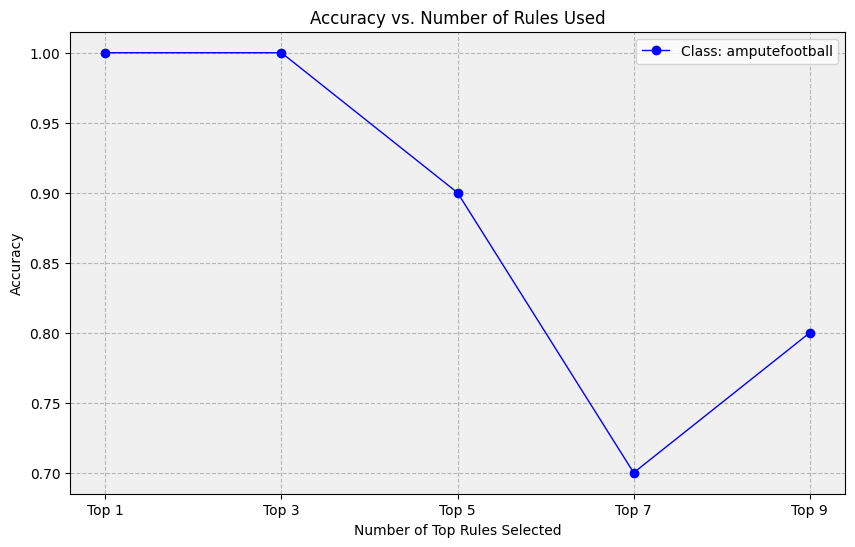

In [59]:
plot.plot_accuracy(X_test, y_test, class_name = class_dict.get("1"), N=9)

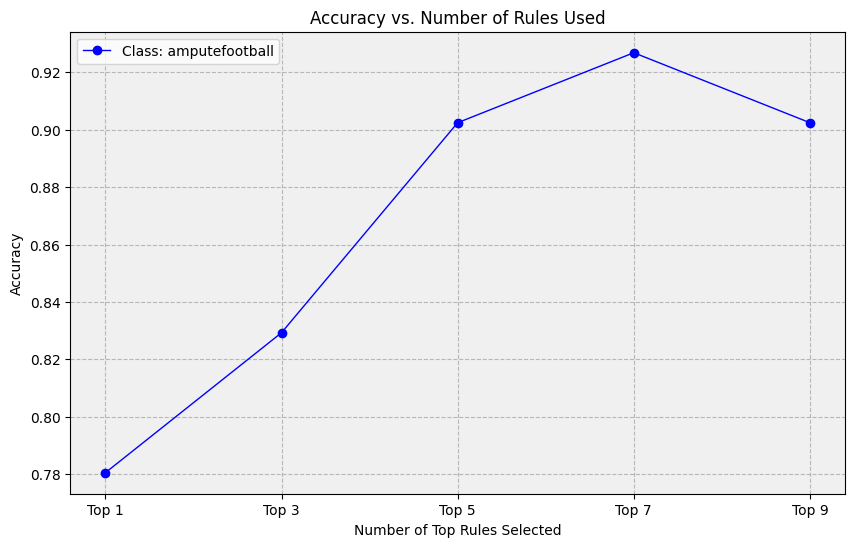

In [60]:
plot.plot_accuracy(X_val, y_val, class_name = class_dict.get("1"), N=9)